In [12]:
import pandas as pd
from pathlib import Path
import numpy as np
from ephys_queries import db_setup_core, select_spike_times
from dotenv import load_dotenv
from spiketimes.df.conversion import df_to_list
from spiketimes.plots import grouped_raster
import matplotlib.pyplot as plt

In [3]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [4]:
group_names = ("chronic_citalopram", 
                           "chronic_saline", 
                           "chronic_saline_", 
                           "citalopram_continuation", 
                           "citalopram_discontinuation")

df = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: 
         (x["group_name"].isin(group_names)
        ) & (
         x["cluster"] != "no_baseline")]
)

In [5]:
block_name = "pre"
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()

In [19]:
session_names = df["session_name"].unique()
session = np.random.choice(session_names, 1)[0]

In [20]:
(
    df[["neuron_id", "session_name","cluster"]]
    .groupby(['session_name', "cluster"])
    .apply(len)
    .reset_index()
    .loc[lambda x: x["session_name"]==session]
)

,session_name,cluster,0
16,hamilton_07,fast_firing,5
17,hamilton_07,slow_irregular,20
18,hamilton_07,slow_regular,19


In [ ]:
session = "hamilton_07"

In [21]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
        session_names=[session]
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)

In [22]:
df_spikes = df_spikes.merge(df[["cluster", "neuron_id"]])

In [23]:
_, slow_regs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, slow_irregs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_irregular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, ffs = df_to_list(df_spikes[df_spikes["cluster"] == "fast_firing"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

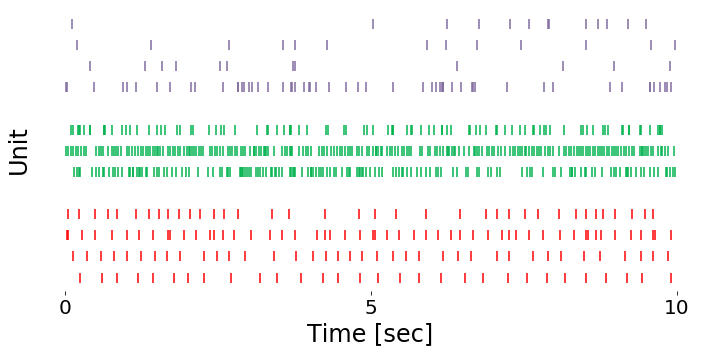

In [55]:
f, ax = plt.subplots(figsize=(10, 5))

t_start = 100
t_stop = t_start + 10


ax = grouped_raster([slow_regs[4::4], ffs[2:], slow_irregs[3:7]],
                    ["#FF0100", "#00B34E", "#806A9D"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax)
ax.set_yticks(ticks=[])
ax.set_yticklabels([])

ax.set_xticks(ticks=[t_start, t_start + 5, t_start + 10])
ax.set_xticklabels([0, 5, 10], fontsize=20)

ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

plt.tight_layout()

plt.savefig(fig_dir / "raster.png", dpi=300, transparent=True)